In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import sys
import random
import wandb
from torch.utils.data import TensorDataset
from tqdm import tqdm



In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

In [3]:
import os

os.environ["WANDB_NOTEBOOK_NAME"] = '/home/agcl/Downloads/CS6910_ASSIGNMENT_3-ATTENTION-model2.ipynb'

In [4]:
wandb.login()

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find /home/agcl/Downloads/CS6910_ASSIGNMENT_3-ATTENTION-model2.ipynb.
wandb: Currently logged in as: ananthu2014. Use `wandb login --relogin` to force relogin


True

In [5]:
'''function to load the data'''
def load_data(path,language_names):
    df=pd.read_csv(path,header=None)
    df.columns=language_names
    return df

In [6]:
'''Here,basically,the input is given to the encoder in English language and is transliterated to Hindi
by the decoder'''
path_train="/home/agcl/Downloads/hin_train.csv"
language_names = ['English','transliteration_in_hindi']
df_train=load_data(path_train,language_names)
print(df_train.shape)
df_train

(51200, 2)


,English,transliteration_in_hindi
0,shastragaar,शस्त्रागार
1,bindhya,बिन्द्या
2,kirankant,किरणकांत
3,yagyopaveet,यज्ञोपवीत
4,ratania,रटानिया
...,...,...
51195,toned,टोंड
51196,mutanaazaa,मुतनाज़ा
51197,asahmaton,असहमतों
51198,sulgaayin,सुलगायीं


In [7]:
#path_test="C:/Users/anant/Downloads/hin_test.csv"
path_test="/home/agcl/Downloads/hin_test.csv"
#path_validation="C:/Users/anant/Downloads/hin_valid.csv"
path_validation="/home/agcl/Downloads/hin_valid.csv"
df_validation=load_data(path_validation,language_names)
print(df_validation.shape)
df_test=load_data(path_test,language_names)
print(df_test.shape)

(4096, 2)
(4096, 2)


In [8]:
'''Function for acquiring all the characters of the given data'''
def split_words(x):
    x=np.array(x)
    alpha=['_','\t','\n',' '] #pad token, start of word, end of word and unknown tokens
    b=[]
    for i in range(x.shape[0]):
        a=list(x[i])
        for j in range(len(a)):
            if a[j] not in b:
                b.append(a[j])
    b=sorted(b)
    alpha=alpha+b
    return alpha

In [9]:
'''All the english characters are stored into the list english_vocab and all the hindi characters are
stored into the list hindi_vocab'''
english_vocab=split_words(df_train['English'])
hindi_vocab=split_words(df_train['transliteration_in_hindi'])

In [10]:
print(len(english_vocab))
print(len(hindi_vocab))
print(english_vocab)
print(hindi_vocab)

30
68
['_', '\t', '\n', ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
['_', '\t', '\n', ' ', 'ँ', 'ं', 'ः', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ए', 'ऐ', 'ऑ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'ळ', 'व', 'श', 'ष', 'स', 'ह', '़', 'ऽ', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'ॅ', 'े', 'ै', 'ॉ', 'ो', 'ौ', '्']


In [11]:
'''Functions to create the vocabulary dictionaries with their indices'''
def int_to_char(vocab):
    int2char={} #padding token, start of word, end of word token and unknown token
    for i in range(len(vocab)):
        int2char[i]=vocab[i][0]
    return int2char

In [12]:
int2char_eng=int_to_char(english_vocab)
print(int2char_eng)

{0: '_', 1: '\t', 2: '\n', 3: ' ', 4: 'a', 5: 'b', 6: 'c', 7: 'd', 8: 'e', 9: 'f', 10: 'g', 11: 'h', 12: 'i', 13: 'j', 14: 'k', 15: 'l', 16: 'm', 17: 'n', 18: 'o', 19: 'p', 20: 'q', 21: 'r', 22: 's', 23: 't', 24: 'u', 25: 'v', 26: 'w', 27: 'x', 28: 'y', 29: 'z'}


In [13]:
def char_to_int(int2char):
    char2int={ch:ii for ii,ch in int2char.items()}
    return char2int

In [14]:
char2int_eng=char_to_int(int2char_eng)
print(char2int_eng)

{'_': 0, '\t': 1, '\n': 2, ' ': 3, 'a': 4, 'b': 5, 'c': 6, 'd': 7, 'e': 8, 'f': 9, 'g': 10, 'h': 11, 'i': 12, 'j': 13, 'k': 14, 'l': 15, 'm': 16, 'n': 17, 'o': 18, 'p': 19, 'q': 20, 'r': 21, 's': 22, 't': 23, 'u': 24, 'v': 25, 'w': 26, 'x': 27, 'y': 28, 'z': 29}


In [15]:
int2char_hin=int_to_char(hindi_vocab)
print(int2char_hin)

{0: '_', 1: '\t', 2: '\n', 3: ' ', 4: 'ँ', 5: 'ं', 6: 'ः', 7: 'अ', 8: 'आ', 9: 'इ', 10: 'ई', 11: 'उ', 12: 'ऊ', 13: 'ऋ', 14: 'ए', 15: 'ऐ', 16: 'ऑ', 17: 'ओ', 18: 'औ', 19: 'क', 20: 'ख', 21: 'ग', 22: 'घ', 23: 'ङ', 24: 'च', 25: 'छ', 26: 'ज', 27: 'झ', 28: 'ञ', 29: 'ट', 30: 'ठ', 31: 'ड', 32: 'ढ', 33: 'ण', 34: 'त', 35: 'थ', 36: 'द', 37: 'ध', 38: 'न', 39: 'प', 40: 'फ', 41: 'ब', 42: 'भ', 43: 'म', 44: 'य', 45: 'र', 46: 'ल', 47: 'ळ', 48: 'व', 49: 'श', 50: 'ष', 51: 'स', 52: 'ह', 53: '़', 54: 'ऽ', 55: 'ा', 56: 'ि', 57: 'ी', 58: 'ु', 59: 'ू', 60: 'ृ', 61: 'ॅ', 62: 'े', 63: 'ै', 64: 'ॉ', 65: 'ो', 66: 'ौ', 67: '्'}


In [16]:
char2int_hin=char_to_int(int2char_hin)
print(char2int_hin)

{'_': 0, '\t': 1, '\n': 2, ' ': 3, 'ँ': 4, 'ं': 5, 'ः': 6, 'अ': 7, 'आ': 8, 'इ': 9, 'ई': 10, 'उ': 11, 'ऊ': 12, 'ऋ': 13, 'ए': 14, 'ऐ': 15, 'ऑ': 16, 'ओ': 17, 'औ': 18, 'क': 19, 'ख': 20, 'ग': 21, 'घ': 22, 'ङ': 23, 'च': 24, 'छ': 25, 'ज': 26, 'झ': 27, 'ञ': 28, 'ट': 29, 'ठ': 30, 'ड': 31, 'ढ': 32, 'ण': 33, 'त': 34, 'थ': 35, 'द': 36, 'ध': 37, 'न': 38, 'प': 39, 'फ': 40, 'ब': 41, 'भ': 42, 'म': 43, 'य': 44, 'र': 45, 'ल': 46, 'ळ': 47, 'व': 48, 'श': 49, 'ष': 50, 'स': 51, 'ह': 52, '़': 53, 'ऽ': 54, 'ा': 55, 'ि': 56, 'ी': 57, 'ु': 58, 'ू': 59, 'ृ': 60, 'ॅ': 61, 'े': 62, 'ै': 63, 'ॉ': 64, 'ो': 65, 'ौ': 66, '्': 67}


In [17]:
'''Finding the maximum sequence length'''
length_eng=[len(i) for i in df_train['English']]
length_hin=[len(i) for i in df_train['transliteration_in_hindi']]

In [18]:
length_eng_max=max(length_eng)+2 #we have to account for the start and end token
print(f'The maximum sequence length of English words is {length_eng_max}')
length_hin_max=max(length_hin)+2
print(f'The maximum sequence length of transliterated words is {length_hin_max}')

The maximum sequence length of English words is 26
The maximum sequence length of transliterated words is 22


In [19]:
num_english_tokens=len(english_vocab)
print(num_english_tokens)

30


In [20]:
num_hindi_tokens=len(hindi_vocab)
print(num_hindi_tokens)

68


In [21]:
print(length_eng_max)
print(length_hin_max)

26
22


In [22]:
print(int2char_eng)
'''The position of padding is zero itself, so we can create tensors using torch.zeros and proceed'''

{0: '_', 1: '\t', 2: '\n', 3: ' ', 4: 'a', 5: 'b', 6: 'c', 7: 'd', 8: 'e', 9: 'f', 10: 'g', 11: 'h', 12: 'i', 13: 'j', 14: 'k', 15: 'l', 16: 'm', 17: 'n', 18: 'o', 19: 'p', 20: 'q', 21: 'r', 22: 's', 23: 't', 24: 'u', 25: 'v', 26: 'w', 27: 'x', 28: 'y', 29: 'z'}


'The position of padding is zero itself, so we can create tensors using torch.zeros and proceed'

In [23]:
def process_data(df,english_vocab=english_vocab,hindi_vocab=hindi_vocab,
                 length_eng_max=length_eng_max,length_hin_max=length_hin_max,char2int_eng=char2int_eng
                 ,char2int_hin=char2int_hin):
    
    '''removing words of length more than max length'''
    df['English'] = df['English'].str.lower()
    df['transliteration_in_hindi'] = df['transliteration_in_hindi'].str.lower()
    df = df[df['English'].apply(len) <= length_eng_max-2]
    df = df[df['transliteration_in_hindi'].apply(len) <= length_hin_max-2]
    '''Adding start and end of word tokens'''
    y_og = df['transliteration_in_hindi'].values
    x_og = df['English'].values
    x = '\t'+x_og+'\n'
    y = '\t'+y_og+'\n'
    y_do=y_og+'\n'
    unknown=3
    pad=0
    pad_char='_'
    unknown_char=' '
    start=1
    end=2
    
    enc_input_data=torch.zeros(len(x),length_eng_max)
    dec_input_data=torch.zeros(len(y),length_hin_max)
    dec_output_data=torch.zeros(len(y),length_hin_max)
    for i, (xx,yy) in enumerate(zip(x,y)):
        for j,char in enumerate(xx):
            enc_input_data[i,j]=char2int_eng[char]
        #pad character is zero so no need of assigning it again
        for j,char in enumerate(yy):
            if char in hindi_vocab:
                dec_input_data[i,j]=char2int_hin[char]
            else:
                dec_input_data[i,j]=char2int_hin[unknown_char]
    
    for i, (xx,yy) in enumerate(zip(x,y_do)):
        for j,char in enumerate(yy):
            if char in hindi_vocab:
                dec_output_data[i,j]=char2int_hin[char]
            else:
                dec_input_data[i,j]=char2int_hin[unknown_char]
                
    return enc_input_data,dec_input_data,dec_output_data

In [24]:
def one_hot_encoding(df,english_vocab=english_vocab,hindi_vocab=hindi_vocab,
                 length_eng_max=length_eng_max,length_hin_max=length_hin_max,char2int_eng=char2int_eng
                 ,char2int_hin=char2int_hin):
    
    
    '''removing words of length more than max length'''
    df = df[df['English'].apply(len) <= length_eng_max-2]
    df = df[df['transliteration_in_hindi'].apply(len) <= length_hin_max-2]
    '''Adding start and end of word tokens'''
    y = df['transliteration_in_hindi'].values
    x= df['English'].values
    x = '\t'+x+'\n'
    y = '\t'+y+'\n'
    
    unknown=3
    pad=0
    pad_char='_'
    unknown_char=' '
    start=1
    end=2
    
    encoder_input_data = np.zeros(
    (len(df['English']), length_eng_max, num_english_tokens), dtype="float32")
    decoder_input_data = np.zeros(
    (len(df['transliteration_in_hindi']), length_hin_max, num_hindi_tokens), dtype="float32")
    decoder_output_data = np.zeros(
    (len(df['transliteration_in_hindi']), length_hin_max, num_hindi_tokens), dtype="float32")
    pad_char='_'
    for i , (input_text,target_text) in enumerate(zip(x,y)):
        for t,char in enumerate(input_text):
            encoder_input_data[i,t,char2int_eng[char]]=1
        encoder_input_data[i,t+1:,char2int_eng[pad_char]]=1
    
        for t,char in enumerate(target_text):
            if char in hindi_vocab:
                decoder_input_data[i,t,char2int_hin[char]]=1
            else:
                decoder_input_data[i,t,char2int_hin[unknown_char]]=1
        decoder_input_data[i,t+1:,char2int_hin[pad_char]]=1
    
        '''decoder target data is one step ahead of decoder input data by one timestep
        and doesnot includes start token'''
        for t,char in enumerate(target_text):
            if t>0:
                if char in hindi_vocab:
                    decoder_output_data[i,t-1,char2int_hin[char]]=1
                else:
                    decoder_output_data[i,t-1,char2int_hin[unknown_char]]=1
                
        decoder_output_data[i,t:,char2int_hin[pad_char]]=1
    
    return torch.tensor(encoder_input_data),torch.tensor(decoder_input_data),torch.tensor(decoder_output_data)
    
    

In [25]:
enc_input_data,dec_input_data,dec_output_data=process_data(df_train)

In [26]:
encoder_input_data,decoder_input_data,decoder_output_data=one_hot_encoding(df_train)

In [27]:
print(enc_input_data.shape)
print(dec_input_data.shape)

torch.Size([51200, 26])
torch.Size([51200, 22])


In [28]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_output_data.shape)

torch.Size([51200, 26, 30])
torch.Size([51200, 22, 68])
torch.Size([51200, 22, 68])


In [29]:
print(dec_input_data[0])

tensor([ 1., 49., 51., 67., 34., 67., 45., 55., 21., 55., 45.,  2.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])


In [30]:
print(dec_output_data[0])

tensor([49., 51., 67., 34., 67., 45., 55., 21., 55., 45.,  2.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])


In [31]:
enc_input_data_test,dec_input_data_test,dec_output_data_test=process_data(df_test)

In [32]:
print(enc_input_data_test.shape)
print(dec_input_data_test.shape)

torch.Size([4095, 26])
torch.Size([4095, 22])


In [33]:
enc_input_data_val,dec_input_data_val,dec_output_data_val=process_data(df_validation)

In [34]:
print(enc_input_data_val.shape)
print(dec_input_data_val.shape)

torch.Size([4096, 26])
torch.Size([4096, 22])


In [35]:
encoder_input_data_test,decoder_input_data_test,decoder_output_data_test=one_hot_encoding(df_test)

In [36]:
print(encoder_input_data_test.shape)
print(decoder_input_data_test.shape)
print(decoder_output_data_test.shape)

torch.Size([4095, 26, 30])
torch.Size([4095, 22, 68])
torch.Size([4095, 22, 68])


In [37]:
encoder_input_data_val,decoder_input_data_val,decoder_output_data_val=one_hot_encoding(df_validation)

In [38]:
print(encoder_input_data_val.shape)
print(decoder_input_data_val.shape)
print(decoder_output_data_val.shape)

torch.Size([4096, 26, 30])
torch.Size([4096, 22, 68])
torch.Size([4096, 22, 68])


In [39]:
print(torch.argmax(decoder_input_data,dim=-1))

tensor([[ 1, 49, 51,  ...,  0,  0,  0],
        [ 1, 41, 56,  ...,  0,  0,  0],
        [ 1, 19, 56,  ...,  0,  0,  0],
        ...,
        [ 1,  7, 51,  ...,  0,  0,  0],
        [ 1, 51, 58,  ...,  0,  0,  0],
        [ 1,  7,  5,  ...,  0,  0,  0]])


In [40]:
print(dec_input_data)

tensor([[ 1., 49., 51.,  ...,  0.,  0.,  0.],
        [ 1., 41., 56.,  ...,  0.,  0.,  0.],
        [ 1., 19., 56.,  ...,  0.,  0.,  0.],
        ...,
        [ 1.,  7., 51.,  ...,  0.,  0.,  0.],
        [ 1., 51., 58.,  ...,  0.,  0.,  0.],
        [ 1.,  7.,  5.,  ...,  0.,  0.,  0.]])


In [41]:
print(torch.argmax(decoder_output_data,dim=-1))

tensor([[49, 51, 67,  ...,  0,  0,  0],
        [41, 56, 38,  ...,  0,  0,  0],
        [19, 56, 45,  ...,  0,  0,  0],
        ...,
        [ 7, 51, 52,  ...,  0,  0,  0],
        [51, 58, 46,  ...,  0,  0,  0],
        [ 7,  5, 24,  ...,  0,  0,  0]])


In [42]:
print(dec_output_data)

tensor([[49., 51., 67.,  ...,  0.,  0.,  0.],
        [41., 56., 38.,  ...,  0.,  0.,  0.],
        [19., 56., 45.,  ...,  0.,  0.,  0.],
        ...,
        [ 7., 51., 52.,  ...,  0.,  0.,  0.],
        [51., 58., 46.,  ...,  0.,  0.,  0.],
        [ 7.,  5., 24.,  ...,  0.,  0.,  0.]])


In [43]:
df_train['transliteration_in_hindi']='\t'+df_train['transliteration_in_hindi']+'\n'
df_train['English']='\t'+df_train['English']+'\n'

In [44]:
df_train['English_seq'] = df_train['English'].apply(lambda x: [char2int_eng[char] for char in x])
df_train['transliteration_seq'] = df_train['transliteration_in_hindi'].apply(lambda x: [char2int_hin[char] for char in x])


In [45]:
df_train

,English,transliteration_in_hindi,English_seq,transliteration_seq
0,\tshastragaar\n,\tशस्त्रागार\n,"[1, 22, 11, 4, 22, 23, 21, 4, 10, 4, 4, 21, 2]","[1, 49, 51, 67, 34, 67, 45, 55, 21, 55, 45, 2]"
1,\tbindhya\n,\tबिन्द्या\n,"[1, 5, 12, 17, 7, 11, 28, 4, 2]","[1, 41, 56, 38, 67, 36, 67, 44, 55, 2]"
2,\tkirankant\n,\tकिरणकांत\n,"[1, 14, 12, 21, 4, 17, 14, 4, 17, 23, 2]","[1, 19, 56, 45, 33, 19, 55, 5, 34, 2]"
3,\tyagyopaveet\n,\tयज्ञोपवीत\n,"[1, 28, 4, 10, 28, 18, 19, 4, 25, 8, 8, 23, 2]","[1, 44, 26, 67, 28, 65, 39, 48, 57, 34, 2]"
4,\tratania\n,\tरटानिया\n,"[1, 21, 4, 23, 4, 17, 12, 4, 2]","[1, 45, 29, 55, 38, 56, 44, 55, 2]"
...,...,...,...,...
51195,\ttoned\n,\tटोंड\n,"[1, 23, 18, 17, 8, 7, 2]","[1, 29, 65, 5, 31, 2]"
51196,\tmutanaazaa\n,\tमुतनाज़ा\n,"[1, 16, 24, 23, 4, 17, 4, 4, 29, 4, 4, 2]","[1, 43, 58, 34, 38, 55, 26, 53, 55, 2]"
51197,\tasahmaton\n,\tअसहमतों\n,"[1, 4, 22, 4, 11, 16, 4, 23, 18, 17, 2]","[1, 7, 51, 52, 43, 34, 65, 5, 2]"
51198,\tsulgaayin\n,\tसुलगायीं\n,"[1, 22, 24, 15, 10, 4, 4, 28, 12, 17, 2]","[1, 51, 58, 46, 21, 55, 44, 57, 5, 2]"


In [46]:
enc_input_data=enc_input_data.long()
dec_input_data=dec_input_data.long()
enc_input_data_test=enc_input_data_test.long()
dec_input_data_test=dec_input_data_test.long()
enc_input_data_val=enc_input_data_val.long()
dec_input_data_val=dec_input_data_val.long()
encoder_input_data=encoder_input_data.long()
decoder_input_data=decoder_input_data.long()
decoder_output_data=decoder_output_data.long()

In [47]:
# def calculate_word_accuracy(dec_predicted_data, dec_output_data):
#     #Here, we have to pass the arguments in the shape(batch_size,sequence_length)
#     batch_size = dec_predicted_data.shape[0]
#     dec_predicted_data=torch.argmax(dec_predicted_data,dim=-1)
#     dec_output_data=torch.argmax(dec_output_data,dim=-1)
#     with torch.no_grad():
#         true_words = 0
#         for i in range(batch_size):
#             mark = True
#             for j in range(dec_predicted_data.shape[1]):
#                 if dec_predicted_data[i, j] == dec_output_data[i, j]:
#                     mark = True
#                 else:
#                     mark = False
#                     break
#             if mark == True:
#                 true_words =true_words+ 1
#     return (true_words / batch_size)*100


In [48]:
def calculate_word_accuracy(dec_predicted_data, dec_output_data):
    # Here, we have to pass the arguments in the shape (batch_size, sequence_length)
    dec_predicted_data = torch.argmax(dec_predicted_data, dim=-1)
    dec_output_data = torch.argmax(dec_output_data, dim=-1)
    
    with torch.no_grad():
        match = (dec_predicted_data == dec_output_data).all(dim=1)
        true_words = match.sum().item()
        batch_size = dec_predicted_data.shape[0]
    
    accuracy = (true_words / batch_size) * 100
    return accuracy


In [49]:
word_acc=calculate_word_accuracy(decoder_input_data,decoder_output_data)

In [50]:
print(word_acc)

0.0


In [51]:
def calculate_char_accuracy(decoder_predicted_data, decoder_output_data):
    #Here, we have to pass the arguments in the shape(batch_size,sequence_length,unique_tokens)
    batch_size, seq_length,unique_tokens = decoder_predicted_data.shape
    dec_predicted_data=torch.argmax(decoder_predicted_data,dim=-1)
    dec_output_data=torch.argmax(decoder_output_data,dim=-1)
    
    with torch.no_grad():
        correct_count = (dec_predicted_data == dec_output_data).sum().item()
        return (correct_count / (seq_length * batch_size))*100


In [52]:
char_accuracy = calculate_char_accuracy(decoder_input_data[7:9,:,:],decoder_input_data[1:3,:,:])

In [53]:
print(char_accuracy)

61.36363636363637


In [54]:
unique_tokens_eng=len(english_vocab)
unique_tokens_hin=len(hindi_vocab)

In [55]:
def data_loader(x,y,z,batch_size,device=device):
    
    x=x.to(device)
    y=y.to(device)
    z=z.to(device)
    combined=TensorDataset(x,y,z)
    loader=DataLoader(combined,batch_size=batch_size,shuffle=False,drop_last=True)#required in test data
    return loader

In [56]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [57]:
class Encoder(nn.Module):
    def __init__(self, embed_dim, hidden_dim, layer_dim, drop_out, bi_dir, cell,unique_tokens_eng):
        '''unique_token_hin is the third dimension in one hot encoding or no of tokens in eng or input size'''
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.cell = cell
        self.bi_dir = bi_dir
        self.unique_tokens_eng=unique_tokens_eng
        self.embed_dim=embed_dim
        self.drop_out=drop_out
        '''The input to the encoder will be of shape (batch_size,sequence_length) and the output size will be
        (batch_size,seq_length,embed_size)'''
        self.dropout=nn.Dropout(p=self.drop_out)

        self.embedding = nn.Embedding(unique_tokens_eng, embed_dim, padding_idx=0) 
        
        self.rnn=nn.RNN(embed_dim,hidden_dim,dropout=self.drop_out,
                        num_layers=layer_dim,bidirectional=bi_dir,batch_first=True)
        self.gru=nn.GRU(embed_dim,hidden_dim,dropout=self.drop_out,
                        num_layers=layer_dim,bidirectional=bi_dir,batch_first=True)
        self.lstm=nn.LSTM(embed_dim,hidden_dim,dropout=self.drop_out,
                         num_layers=layer_dim,bidirectional=bi_dir,batch_first=True)

    def forward(self, x,hidden):
        '''Here, x is the encoder input data'''
        batch_size=x.size(0)
        x=x.to(device)
        embedding_input = self.embedding(x.long())
        embedding_input = self.dropout(embedding_input)
        #print(embedding_input.shape)
#         if self.cell == "LSTM":
#             h_0 =torch.randn((1 + int(self.bi_dir)) * self.layer_dim, batch_size, self.hidden_dim, device=device)
#             c_0=torch.randn((1 + int(self.bi_dir)) * self.layer_dim, batch_size, self.hidden_dim, device=device)  
#         else:
#             h_0=torch.randn((1 + int(self.bi_dir)) * self.layer_dim, batch_size, self.hidden_dim, device=device)
              
        if self.cell=="GRU":
            output,h_n=self.gru(embedding_input,hidden)#h_0.detach())
            #print(output.shape)
            #print(h_n.shape)
            return output,h_n
        elif self.cell=='RNN':
            output,h_n=self.gru(embedding_input,hidden)#.detach())
            #print(output.shape)
            #print(h_n.shape)
            return output,h_n
        elif self.cell=='LSTM':
            output,(h_n,c_n)=self.lstm(embedding_input,hidden)
            #(h_0.detach(),c_0.detach()))
            #print(output.shape)
            #print(h_n.shape)
            #print(c_n.shape)
            return output,(h_n,c_n)
            
    def encoder_initial(self,batch_size,device=device):
        if self.cell == "LSTM":
            h_0 =torch.randn((1 + int(self.bi_dir)) * self.layer_dim, batch_size, self.hidden_dim, device=device)
            c_0 =torch.randn((1 + int(self.bi_dir)) * self.layer_dim, batch_size, self.hidden_dim, device=device) 
            return (h_0,c_0)
        #H_0,C_0 HAVE SAME DIMENSION
        else:
            h_0=torch.randn((1 + int(self.bi_dir)) * self.layer_dim, batch_size, self.hidden_dim, device=device)
            return h_0

In [58]:
# class Decoder_attention(nn.Module):
#     def __init__(self, embed_dim, hidden_dim, layer_dim, drop_out, bi_dir, cell,
#                  unique_tokens_hin, input_length,target_length):
#         '''unique_token_hin is the third dimension in one hot encoding or no of tokens in hindi or output size'''
#         #input_length is the sequence length of encoder input(english)
#         super(Decoder_attention, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.layer_dim = layer_dim
#         self.cell = cell
#         self.bi_dir = bi_dir
#         self.unique_tokens_hin = unique_tokens_hin
#         self.embed_dim = embed_dim
#         self.drop_out = drop_out
#         self.input_length = input_length
#         self.target_length=target_length
        
#         self.embedding = nn.Embedding(unique_tokens_hin, embed_dim, padding_idx=0)
#         self.dropout = nn.Dropout(p=self.drop_out)
#         self.UattnSt_1 = nn.Linear(hidden_dim*(int(self.bi_dir)+1),hidden_dim*(int(self.bi_dir)+1)) #St-1 is of shape (num_layers(1+D),batch_size,hidden_dim),which should be 
#         #converted into (batch_size,1,hidden_dim). So ,either reshape it accordingly or take it from decoder rnn
#         #output; not after softmax.output after this:(batch_size,1,hidden_dim)
#         self.Wattnh_j = nn.Linear(hidden_dim*(int(self.bi_dir)+1),hidden_dim*(int(self.bi_dir)+1))#h_j contains all the encoder hidden states,taken from encoder outputs, which is 
#         #of shape(batch_size,input_tokens,hidden_dim).output(batch_size,input_tokens,hidden_dim)
#         self.tanh = nn.Tanh()
#         self.e_jt = nn.Linear(hidden_dim*(int(self.bi_dir)+1),1)#Vattn.T process is performed.Output gives attention score of shape
#         #(batch_size,input_tokens,1).
#         self.alpha_jt=nn.Softmax(dim=-1)
#         self.rnn = nn.RNN(self.embed_dim + hidden_dim*(int(self.bi_dir)+1) , hidden_dim,
#                     num_layers=self.layer_dim, batch_first=True, bidirectional=self.bi_dir, dropout=self.drop_out)
#         self.gru = nn.GRU(self.embed_dim + hidden_dim*(int(self.bi_dir)+1) , hidden_dim,
#                     num_layers=self.layer_dim, batch_first=True, bidirectional=self.bi_dir, dropout=self.drop_out)
#         self.lstm = nn.LSTM(self.embed_dim + hidden_dim*(int(self.bi_dir)+1), hidden_dim,
#                     num_layers=self.layer_dim, batch_first=True, bidirectional=self.bi_dir, dropout=self.drop_out)
#         self.relu = nn.ReLU()
#         self.out_put = nn.Linear((1 + int(self.bi_dir)) * self.hidden_dim, self.unique_tokens_hin)
#         self.softmax = nn.LogSoftmax(dim=-1)



#     def forward(self, x, hidden, encoder_outputs):
#         batch_size = x.size(0)
#         x=x.to(device)
#         embedding_output = self.embedding(x.long())
#         embedding_output=embedding_output.to(device)
#         embedding_output = self.dropout(embedding_output)
#         #print('hidden[0]',hidden[0].shape)
#         if self.bi_dir == False:
#             if self.cell == 'LSTM':
#                 st_1=torch.mean(hidden[0],dim=0,keepdim=True).squeeze(dim=0).unsqueeze(dim=1)
#                 #print('st1 initial',st_1.shape)
#             else:
#                 st_1=torch.mean(hidden,dim=0,keepdim=True).squeeze(dim=0).unsqueeze(dim=1)
                
#         elif self.bi_dir == True: # encoorporates for multiple layers and bidirection
#             if self.cell == 'LSTM':
#                 h=hidden[0]
#                 h_forward = h[:self.layer_dim]
#                 h_backward=h[self.layer_dim:]
#                 h=torch.cat((h_forward,h_backward),dim=-1)
#                 h=torch.mean(h,dim=0,keepdim=True)
#                 st_1=h.squeeze(dim=0).unsqueeze(dim=1)
#             else:
#                 h=hidden
#                 h_forward = h[:self.layer_dim]
#                 h_backward=h[self.layer_dim:]
#                 #print(h_forward.shape)
#                 #print(h_backward.shape)
#                 h=torch.cat((h_forward,h_backward),dim=-1)
#                 h=torch.mean(h,dim=0,keepdim=True)
#                 st_1=h.squeeze(dim=0).unsqueeze(dim=1)
                
        
#         #print('st1 final',st_1.shape)
#         a = self.UattnSt_1(st_1) 
#         b = self.Wattnh_j(encoder_outputs)
#         #print('a',a.shape)
#         #print('b',b.shape)
#         att=a+b
#         att=self.tanh(att)
#         attention_score = self.e_jt(att)
#         attention_weights=self.alpha_jt(attention_score)#each column consists of one words' att. weights
#         attention_weights = attention_weights.squeeze(dim=-1)
#         attention_weights = attention_weights.unsqueeze(dim=1)#Now,each row consists of one words' att. weights
#         context = torch.bmm(attention_weights,encoder_outputs)
#         #print('context',context.shape)
#         #print('emb',embedding_output.shape)
#         concatenated_output = torch.cat((embedding_output, context), dim=2)
#         #(batch_size,1,embed_dim+hidden_dim)
#         #concatenated_output =self.relu(concatenated_output)
#         #print('ip',concatenated_output.shape)

#         if self.cell=="GRU":
#             output,h_n=self.gru(concatenated_output,hidden)#.detach())
#             output = self.softmax(self.out_put(output))
#             return output,h_n,attention_weights
#             #print(output.shape)
#             #print(h_n.shape)
#         elif self.cell=='RNN':
#             output,h_n=self.gru(concatenated_output,hidden)#.detach())
#             return output,h_n,attention_weights
#             #print(output.shape)
#             #print(h_n.shape)
#         elif self.cell=='LSTM':
#             output,(h_n,c_n)=self.lstm(concatenated_output,hidden)
#             output = self.softmax(self.out_put(output))
#             return output,(h_n,c_n),attention_weights
#             #(h_0.detach(),c_0.detach()))
#             #print(output.shape)
#             #print(h_n.shape)
#             #print(c_n.shape)
#         #print(output.shape)
        
#         #print(output.shape)
#         #print('hi')
            

#     def decoder_attn_initial(self, batch_size, device=device):
#         if self.cell == "LSTM":
#             h_0 = torch.randn((1 + int(self.bi_dir)) * self.layer_dim, batch_size, self.hidden_dim,device=device)
#             c_0 = torch.randn((1 + int(self.bi_dir)) * self.layer_dim, batch_size, self.hidden_dim,device=device)
#             return (h_0,c_0)
#         else:
#             h_0 = torch.randn((1 + int(self.bi_dir)) * self.layer_dim, batch_size, self.hidden_dim,device=device)
#             return h_0



In [59]:
# class Decoder_attention(nn.Module):
#     def __init__(self, embed_dim, hidden_dim, layer_dim, drop_out, bi_dir, cell,
#                  unique_tokens_hin, input_length,target_length):
#         '''unique_token_hin is the third dimension in one hot encoding or no of tokens in hindi or output size'''
#         #input_length is the sequence length of encoder input(english)
#         super(Decoder_attention, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.layer_dim = layer_dim
#         self.cell = cell
#         self.bi_dir = bi_dir
#         self.unique_tokens_hin = unique_tokens_hin
#         self.embed_dim = embed_dim
#         self.drop_out = drop_out
#         self.input_length = input_length
#         self.target_length=target_length
        
#         self.embedding = nn.Embedding(unique_tokens_hin, embed_dim)
#         self.dropout = nn.Dropout(p=self.drop_out)
#         self.UattnSt_1 = nn.Linear(hidden_dim,hidden_dim) 
#         self.Wattnh_j = nn.Linear(hidden_dim,hidden_dim)
#         self.tanh = nn.Tanh()
#         self.e_jt = nn.Linear(hidden_dim,1)
#         self.alpha_jt=nn.Softmax(dim=-1)
#         self.rnn = nn.RNN(self.embed_dim + hidden_dim*layer_dim*(1+int(bi_dir)) , hidden_dim,
#                     num_layers=self.layer_dim, batch_first=True, bidirectional=self.bi_dir, dropout=self.drop_out)
#         self.gru = nn.GRU(self.embed_dim + hidden_dim*layer_dim*(1+int(bi_dir)) , hidden_dim,
#                     num_layers=self.layer_dim, batch_first=True, bidirectional=self.bi_dir, dropout=self.drop_out)
#         self.lstm = nn.LSTM(self.embed_dim + hidden_dim*layer_dim*(1+int(bi_dir)), hidden_dim,
#                     num_layers=self.layer_dim, batch_first=True, bidirectional=self.bi_dir, dropout=self.drop_out)
#         self.relu = nn.ReLU()
#         self.out_put = nn.Linear((1 + int(self.bi_dir)) * self.hidden_dim, self.unique_tokens_hin)
#         self.softmax = nn.LogSoftmax(dim=-1)



#     def forward(self, x, hidden, encoder_outputs):
#         batch_size = x.size(0)
#         x=x.to(device)
#         embedding_output = self.embedding(x.long())
#         embedding_output=embedding_output.to(device)
#         embedding_output = self.dropout(embedding_output)
       
#         if self.cell =='LSTM':
#             st_1 = hidden[0].unsqueeze(dim=2)
#         else:
#             st_1 = hidden.unsqueeze(dim=2)
            
#         a = self.UattnSt_1(st_1) 
#         b = self.Wattnh_j(encoder_outputs)

#         att=a+b
#         att=self.tanh(att)
#         attention_score = self.e_jt(att)
#         attention_weights=self.alpha_jt(attention_score)
#         attention_weights = attention_weights.squeeze(dim=-1)
#         attention_weights = attention_weights.unsqueeze(dim=2)
#         context = torch.zeros(self.layer_dim*(1+int(self.bi_dir)),batch_size,1,self.hidden_dim)
#         for i in range(context.shape[0]):
    
            
#             context[i,:,:,:] = torch.bmm(attention_weights[i].squeeze(0),encoder_outputs[i].squeeze(0))
    

#         context = context.reshape(batch_size,self.hidden_dim*(1+int(self.bi_dir))*self.layer_dim)
#         context=context.unsqueeze(1)
    
#         context=context.to(device)
#         #print(context.shape)
#         concatenated_output = torch.cat((embedding_output, context), dim=2)
#         #(batch_size,1,embed_dim+hidden_dim)
#         concatenated_output =self.relu(concatenated_output)


#         if self.cell=="GRU":
#             output,h_n=self.gru(concatenated_output,hidden)#.detach())
#             output = self.softmax(self.out_put(output))
#             return output,h_n,attention_weights
           
#         elif self.cell=='RNN':
#             output,h_n=self.gru(concatenated_output,hidden)#.detach())
#             return output,h_n,attention_weights
            
#         elif self.cell=='LSTM':
#             output,(h_n,c_n)=self.lstm(concatenated_output,hidden)
#             output = self.softmax(self.out_put(output))
#             return output,(h_n,c_n),attention_weights
            
            

#     def decoder_attn_initial(self, batch_size, device=device):
#         if self.cell == "LSTM":
#             h_0 = torch.randn((1 + int(self.bi_dir)) * self.layer_dim, batch_size, self.hidden_dim,device=device)
#             c_0 = torch.randn((1 + int(self.bi_dir)) * self.layer_dim, batch_size, self.hidden_dim,device=device)
#             return (h_0,c_0)
#         else:
#             h_0 = torch.randn((1 + int(self.bi_dir)) * self.layer_dim, batch_size, self.hidden_dim,device=device)
#             return h_0



In [60]:
# class Decoder_attention(nn.Module):
#     def __init__(self, embed_dim, hidden_dim, layer_dim, drop_out, bi_dir, cell,
#                  unique_tokens_hin, input_length,target_length):
#         '''unique_token_hin is the third dimension in one hot encoding or no of tokens in hindi or output size'''
#         #input_length is the sequence length of encoder input(english)
#         super(Decoder_attention, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.layer_dim = layer_dim
#         self.cell = cell
#         self.bi_dir = bi_dir
#         self.unique_tokens_hin = unique_tokens_hin
#         self.embed_dim = embed_dim
#         self.drop_out = drop_out
#         self.input_length = input_length
#         self.target_length=target_length
        
#         self.embedding = nn.Embedding(unique_tokens_hin, embed_dim)
#         self.dropout = nn.Dropout(p=self.drop_out)
#         self.UattnSt_1 = nn.Linear(hidden_dim,hidden_dim) 
#         self.Wattnh_j = nn.Linear(hidden_dim,hidden_dim)
#         self.tanh = nn.Tanh()
#         self.e_jt = nn.Linear(hidden_dim,1)
#         self.alpha_jt=nn.Softmax(dim=2)
#         self.rnn = nn.RNN(embed_dim + hidden_dim, hidden_dim,
#                     num_layers=self.layer_dim, batch_first=True, bidirectional=self.bi_dir, dropout=self.drop_out)
#         self.gru = nn.GRU(embed_dim + hidden_dim , hidden_dim,
#                     num_layers=self.layer_dim, batch_first=True, bidirectional=self.bi_dir, dropout=self.drop_out)
#         self.lstm = nn.LSTM(embed_dim + hidden_dim, hidden_dim,
#                     num_layers=self.layer_dim, batch_first=True, bidirectional=self.bi_dir, dropout=self.drop_out)
#         self.relu = nn.ReLU()
#         self.out_put = nn.Linear((1 + int(self.bi_dir)) * self.hidden_dim, self.unique_tokens_hin)
#         self.softmax = nn.LogSoftmax(dim=-1)



#     def forward(self, x, hidden, encoder_outputs):
#         batch_size = x.size(0)
#         x=x.to(device)
#         embedding_output = self.embedding(x.long())
#         embedding_output=embedding_output.to(device)
#         embedding_output = self.dropout(embedding_output)
       
#         if self.cell =='LSTM':
#             st_1 = hidden[0].unsqueeze(dim=2)
#         else:
#             st_1 = hidden.unsqueeze(dim=2)
            
#         a = self.UattnSt_1(st_1) 
#         b = self.Wattnh_j(encoder_outputs)

#         att=a+b
#         att=self.tanh(att)
#         attention_score = self.e_jt(att)
#         attention_weights=self.alpha_jt(attention_score)
#         #print(attention_weights.shape)
#         attention_weights = torch.mean(attention_weights,dim=0).squeeze(1)
#         #print(attention_weights.shape)
#         attention_weights=attention_weights.squeeze(-1).unsqueeze(1)
#         h_j = torch.mean(encoder_outputs,dim=0).squeeze(0)
        
#         context_vector = torch.bmm(attention_weights,h_j)

    
#         context_vector=context_vector.to(device)
#         #print(context.shape)
#         concatenated_output = torch.cat((embedding_output, context_vector), dim=2)
#         #(batch_size,1,embed_dim+hidden_dim)
#         concatenated_output =self.relu(concatenated_output)


#         if self.cell=="GRU":
#             output,h_n=self.gru(concatenated_output,hidden)#.detach())
#             output = self.softmax(self.out_put(output))
#             return output,h_n,attention_weights
           
#         elif self.cell=='RNN':
#             output,h_n=self.gru(concatenated_output,hidden)#.detach())
#             return output,h_n,attention_weights
            
#         elif self.cell=='LSTM':
#             output,(h_n,c_n)=self.lstm(concatenated_output,hidden)
#             output = self.softmax(self.out_put(output))
#             return output,(h_n,c_n),attention_weights
            
            

#     def decoder_attn_initial(self, batch_size, device=device):
#         if self.cell == "LSTM":
#             h_0 = torch.randn((1 + int(self.bi_dir)) * self.layer_dim, batch_size, self.hidden_dim,device=device)
#             c_0 = torch.randn((1 + int(self.bi_dir)) * self.layer_dim, batch_size, self.hidden_dim,device=device)
#             return (h_0,c_0)
#         else:
#             h_0 = torch.randn((1 + int(self.bi_dir)) * self.layer_dim, batch_size, self.hidden_dim,device=device)
#             return h_0



In [61]:
class Decoder_attention(nn.Module):
    def __init__(self, embed_dim, hidden_dim, layer_dim, drop_out, bi_dir, cell,
                 unique_tokens_hin, input_length,target_length):
        '''unique_token_hin is the third dimension in one hot encoding or no of tokens in hindi or output size'''
        #input_length is the sequence length of encoder input(english)
        super(Decoder_attention, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.cell = cell
        self.bi_dir = bi_dir
        self.unique_tokens_hin = unique_tokens_hin
        self.embed_dim = embed_dim
        self.drop_out = drop_out
        self.input_length = input_length
        self.target_length=target_length
        
        self.embedding = nn.Embedding(unique_tokens_hin, embed_dim)
        self.dropout = nn.Dropout(p=self.drop_out)
        self.UattnSt_1 = nn.Linear(hidden_dim,hidden_dim) 
        self.Wattnh_j = nn.Linear(hidden_dim,hidden_dim)
        self.tanh = nn.Tanh()
        self.e_jt = nn.Linear(hidden_dim,1)
        self.alpha_jt=nn.Softmax(dim=1)
        self.rnn = nn.RNN(embed_dim + hidden_dim, hidden_dim,
                    num_layers=self.layer_dim, batch_first=True, bidirectional=self.bi_dir, dropout=self.drop_out)
        self.gru = nn.GRU(embed_dim + hidden_dim , hidden_dim,
                    num_layers=self.layer_dim, batch_first=True, bidirectional=self.bi_dir, dropout=self.drop_out)
        self.lstm = nn.LSTM(embed_dim + hidden_dim, hidden_dim,
                    num_layers=self.layer_dim, batch_first=True, bidirectional=self.bi_dir, dropout=self.drop_out)
        self.relu = nn.ReLU()
        self.out_put = nn.Linear((1 + int(self.bi_dir)) * self.hidden_dim, self.unique_tokens_hin)
        self.softmax = nn.LogSoftmax(dim=-1)



    def forward(self, x, hidden, encoder_outputs):
        batch_size = x.size(0)
        x=x.to(device)
        embedding_output = self.embedding(x.long())
        embedding_output=embedding_output.to(device)
        embedding_output = self.dropout(embedding_output)
       
        if self.cell =='LSTM':
            st_1 = hidden[0]#.unsqueeze(dim=2)
        else:
            st_1 = hidden#.unsqueeze(dim=2)
        
        encoder_outputs = torch.mean(encoder_outputs,dim=0)
        encoder_outputs = encoder_outputs.squeeze(0)
        st_1 = torch.mean(st_1,dim=0).squeeze(0).unsqueeze(1)
        #print(encoder_outputs.shape)
        #print(st_1.shape)
        a = self.UattnSt_1(st_1) 
        b = self.Wattnh_j(encoder_outputs)

        att=a+b
        att=self.tanh(att)
        attention_score = self.e_jt(att)
        attention_weights=self.alpha_jt(attention_score)
        #print(attention_weights.shape)
        #attention_weights = torch.mean(attention_weights,dim=0).squeeze(1)
        #print(attention_weights.shape)
        attention_weights=attention_weights.squeeze(-1).unsqueeze(1)
        #h_j = torch.mean(encoder_outputs,dim=0).squeeze(0)
        
        context_vector = torch.bmm(attention_weights,encoder_outputs)

    
        context_vector=context_vector.to(device)
        #print(context.shape)
        concatenated_output = torch.cat((embedding_output, context_vector), dim=2)
        #(batch_size,1,embed_dim+hidden_dim)
        concatenated_output =self.relu(concatenated_output)


        if self.cell=="GRU":
            output,h_n=self.gru(concatenated_output,hidden)#.detach())
            output = self.softmax(self.out_put(output))
            return output,h_n,attention_weights
           
        elif self.cell=='RNN':
            output,h_n=self.gru(concatenated_output,hidden)#.detach())
            return output,h_n,attention_weights
            
        elif self.cell=='LSTM':
            output,(h_n,c_n)=self.lstm(concatenated_output,hidden)
            output = self.softmax(self.out_put(output))
            return output,(h_n,c_n),attention_weights
            
            

    def decoder_attn_initial(self, batch_size, device=device):
        if self.cell == "LSTM":
            h_0 = torch.randn((1 + int(self.bi_dir)) * self.layer_dim, batch_size, self.hidden_dim,device=device)
            c_0 = torch.randn((1 + int(self.bi_dir)) * self.layer_dim, batch_size, self.hidden_dim,device=device)
            return (h_0,c_0)
        else:
            h_0 = torch.randn((1 + int(self.bi_dir)) * self.layer_dim, batch_size, self.hidden_dim,device=device)
            return h_0



In [62]:
'''To use when the number of encoder and decoder layers are different'''
class Reshape(nn.Module):
    def __init__(self, num_enc_layers, num_dec_layers, cell, bi_dir):
        super(Reshape, self).__init__()
        self.num_enc_layers = num_enc_layers
        self.num_dec_layers = num_dec_layers
        self.cell = cell
        self.bi_dir = bi_dir
        self.linear = nn.Linear(num_enc_layers * int(1 + bi_dir), num_dec_layers * int(1 + bi_dir))

    def forward(self, h_n_enc):
        if self.cell == 'LSTM':
            x=x.permute(*torch.arange(x.ndim - 1, -1, -1))
            h_dec = self.linear(h_n_enc[0].permute(*torch.arange(h_n_enc.ndim - 1, -1, -1)))
            c_dec = self.linear(h_n_enc[1].permute(*torch.arange(c_n_enc.ndim - 1, -1, -1)))
            h_0_dec = (h_dec.permute(*torch.arange(h_dec.ndim - 1, -1, -1)),
                       c_dec.permute(*torch.arange(c_dec.ndim - 1, -1, -1)))
        else:
            h_0_dec = self.linear(h_n_enc.permute(*torch.arange(h_n_enc.ndim - 1, -1, -1)))
            h_0_dec = h_0_dec.permute(*torch.arange(h_0_dec.ndim - 1, -1, -1))
        return h_0_dec


In [63]:
def gradient(input_tensor, target_tensor,target_onehot, encoder_model, decoder_model, encoder_optimizer,
          decoder_optimizer,hidden_dim,criterion,input_length,target_length,batch_size,
             teacher_forcing_ratio,layer_dim,bi_dir,cell,reshape,ropt,device=device):
    
    
    h_0_enc = encoder_model.encoder_initial(batch_size)
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    #ropt.zero_grad()
    uh=target_onehot.shape[-1]
    decoder_predicted=torch.zeros(batch_size,target_length,uh,device=device)
    loss = 0
    encoder_outputs = torch.zeros(layer_dim * (1 + int(bi_dir)), batch_size, input_length, hidden_dim, device=device)
    
    encoder_model.train()
    decoder_model.train()
    #reshape.train()
    
    '''Encoder model is given and the representation of input word is taken from it'''
    for i in range(input_length):
        output_enc, h_n_enc = encoder_model(input_tensor[:,i].unsqueeze(1), h_0_enc)
        if cell =='LSTM':
            encoder_outputs[:,:,i:i+1,:]  = h_n_enc[0].unsqueeze(2)
        else:
             encoder_outputs[:,:,i:i+1,:]  = h_n_enc.unsqueeze(2)
            
        h_0_enc=h_n_enc

    dec_input = torch.ones(batch_size,1,device=device)#start token is given as the input and the indices is 1.
    #h_0_dec=reshape(h_n_enc)
    h_0_dec=h_n_enc
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for i in range(target_length):
            output_dec, h_n_dec,attention_weights = decoder_model(dec_input, h_0_dec,encoder_outputs)
            decoder_predicted[:, i, :] = output_dec.squeeze(1)
            loss += criterion(output_dec.reshape(-1,uh).float(), target_onehot[:,i:i+1,:].reshape(-1,uh).float())
            #loss+=criterion(output_dec.view(-1,uh).float(),target_tensor[:,i].long())
            dec_input = target_tensor[:,i].unsqueeze(1)  # Teacher forcing
            h_0_dec = h_n_dec
            

    else:
        # Without teacher forcing: use its own predictions as the next input
        for i in range(target_length):
            output_dec, h_n_dec,attention_weights = decoder_model(dec_input, h_0_dec,encoder_outputs)
            #top_values, top_indices = output_dec.topk(k=1, dim=2)
            #dec_input = top_indices.view(-1,1).detach()# detach from history as input
            dec_input = torch.argmax(output_dec,dim=-1)
            decoder_predicted[:, i, :] = output_dec.squeeze(1)
            loss += criterion(output_dec.reshape(-1,uh).float(), target_onehot[:,i:i+1,:].reshape(-1,uh).float())
            #loss+=criterion(output_dec.view(-1,uh).float(),target_tensor[:,i].long())
            h_0_dec=h_n_dec
    
            
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()
    #ropt.step()
    
    loss_batch = loss.item() / target_length
    char_acc_batch = calculate_char_accuracy(decoder_predicted,target_onehot)
    word_acc_batch = calculate_word_accuracy(decoder_predicted,target_onehot)
    return loss_batch, char_acc_batch, word_acc_batch


In [64]:
def testing(input_tensor, target_tensor,target_onehot, 
            encoder_model, decoder_model,
          hidden_dim,criterion,input_length,target_length,batch_size,
             layer_dim,bi_dir,cell,reshape,device=device):
    
    encoder_outputs = torch.zeros(layer_dim * (1 + int(bi_dir)), batch_size, input_length, hidden_dim, device=device)
    h_0_enc = encoder_model.encoder_initial(batch_size)
    uh=target_onehot.shape[-1]
    decoder_predicted=torch.zeros(batch_size,target_length,uh,device=device)
    loss = 0
    att_weights = torch.zeros(batch_size,target_length,input_length).to(device)
    encoder_model.eval()
    decoder_model.eval()
    #reshape.eval()
    #print('hi')
    '''Encoder model is given and the representation of input word is taken from it'''
    for i in range(input_length):
        output_enc, h_n_enc = encoder_model(input_tensor[:,i].unsqueeze(1), h_0_enc)
        
        if cell =='LSTM':
            encoder_outputs[:,:,i:i+1,:]  = h_n_enc[0].unsqueeze(2)
        else:
             encoder_outputs[:,:,i:i+1,:]  = h_n_enc.unsqueeze(2)
        h_0_enc=h_n_enc

    dec_input = torch.ones(batch_size,1,device=device)#start token is given as the input and the indices is 1.
    #h_0_dec=reshape(h_n_enc)
    h_0_dec=h_n_enc
    
    # Without teacher forcing: use its own predictions as the next input
    for i in range(target_length):
        output_dec, h_n_dec, attention_weights= decoder_model(dec_input, h_0_dec,encoder_outputs)
        #top_values, top_indices = output_dec.topk(k=1, dim=2)
        #dec_input = top_indices.view(-1,1).detach()# detach from history as input
        att_weights[:,i:i+1,:] = attention_weights
        dec_input = torch.argmax(output_dec,dim=-1)
        decoder_predicted[:, i, :] = output_dec.squeeze(1)
        h_0_dec=h_n_dec
        loss += criterion(output_dec.reshape(-1,uh).float(), target_onehot[:,i:i+1,:].reshape(-1,uh).float())
        #loss+=criterion(output_dec.view(-1,uh).float(),target_tensor[:,i].long())
    
    loss_batch = loss.item() / target_length
    char_acc_batch = calculate_char_accuracy(decoder_predicted,target_onehot)
    word_acc_batch = calculate_word_accuracy(decoder_predicted,target_onehot)
    return loss_batch, char_acc_batch, word_acc_batch,att_weights,decoder_predicted


In [69]:
def train(x=enc_input_data,y=dec_output_data,yonehot=decoder_output_data,
          x_val=enc_input_data_val,y_val=dec_output_data_val,yonehot_val=decoder_output_data_val,
          epochs=15,optimizer='Adam',learning_rate=0.001,weight_decay=0.0001,layer_dim=2,bi_dir=True,
          teacher_forcing_ratio=0.5,cell='LSTM',embed_dim=256,hidden_dim=256,batch_size=64,drop_out=0.2):
    
    
    start = time.time()
    input_length = x.shape[1]
    target_length = y.shape[1]
    num_enc_layers=layer_dim
    num_dec_layers=layer_dim
    
    encoder_model = Encoder(embed_dim, hidden_dim, num_enc_layers, drop_out, bi_dir, cell,unique_tokens_eng).to(device)
    decoder_model = Decoder_attention(embed_dim, hidden_dim,layer_dim,drop_out,bi_dir,cell,unique_tokens_hin,
                                      input_length,target_length).to(device)
    reshape=Reshape(num_enc_layers, num_dec_layers, cell, bi_dir).to(device)
    if optimizer=='Adam':
        
        encoder_optimizer=torch.optim.Adam(encoder_model.parameters(),lr=learning_rate,weight_decay=weight_decay)
        decoder_optimizer=torch.optim.Adam(decoder_model.parameters(),lr=learning_rate,weight_decay=weight_decay)
        #ropt = torch.optim.Adam(reshape.parameters(),lr=learning_rate,weight_decay=weight_decay)
    elif optimizer=='NAdam':
        
        encoder_optimizer=torch.optim.NAdam(encoder_model.parameters(),lr=learning_rate,weight_decay=weight_decay)
        decoder_optimizer=torch.optim.NAdam(decoder_model.parameters(),lr=learning_rate,weight_decay=weight_decay)
        # ropt = torch.optim.NAdam(reshape.parameters(),lr=learning_rate,weight_decay=weight_decay)
    elif optimizer=='SGD':
        
        encoder_optimizer=torch.optim.SGD(encoder_model.parameters(),lr=learning_rate,weight_decay=weight_decay)
        decoder_optimizer=torch.optim.SGD(decoder_model.parameters(),lr=learning_rate,weight_decay=weight_decay)
        ropt = torch.optim.SGD(reshape.parameters(),lr=learning_rate,weight_decay=weight_decay)
        
    train_loader = data_loader(x,y,yonehot,batch_size,device=device)
    val_loader = data_loader(x_val,y_val,yonehot_val,batch_size,device=device)
    
    criterion = nn.CrossEntropyLoss()
    #criterion=nn.NLLLoss()
    
    epoch_losses=[]
    epoch_char_accuracy=[]
    epoch_word_accuracy=[]
    epoch_losses_val=[]
    epoch_char_accuracy_val=[]
    epoch_word_accuracy_val=[]
    
    for i in range(1, epochs + 1):
        batch_losses=[]
        batch_char_acc=[]
        batch_word_acc=[]
        batch_losses_val=[]
        batch_char_acc_val=[]
        batch_word_acc_val=[]
        for enc_input_tensor,dec_target_tensor,dec_onehot in train_loader:
            
            loss_batch,char_acc_batch,word_acc_batch = gradient(enc_input_tensor,dec_target_tensor,dec_onehot,
                    encoder_model,decoder_model,encoder_optimizer,decoder_optimizer,
                    hidden_dim,criterion,input_length,target_length,batch_size, teacher_forcing_ratio,
                            layer_dim,bi_dir,cell,reshape,ropt,device=device)
            
        for enc_input_tensor_val,dec_target_tensor_val,dec_onehot_val in val_loader: 
            
            loss_batch_val,char_acc_batch_val,word_acc_batch_val,attention_weights,decoder_predicted=testing(enc_input_tensor_val,dec_target_tensor_val,
                        dec_onehot_val,encoder_model,decoder_model,hidden_dim,criterion,input_length,
                        target_length,batch_size,layer_dim,bi_dir,cell,reshape,device=device)
          
            batch_losses.append(loss_batch)
            batch_char_acc.append(char_acc_batch)
            batch_word_acc.append(word_acc_batch)
            batch_losses_val.append(loss_batch_val)
            batch_char_acc_val.append(char_acc_batch_val)
            batch_word_acc_val.append(word_acc_batch_val)
            
            
        epoch_loss=sum(batch_losses)/len(batch_losses)
        epoch_char_acc=sum(batch_char_acc)/len(batch_char_acc)
        epoch_word_acc=sum(batch_word_acc)/len(batch_word_acc)
        epoch_losses.append(epoch_loss)
        epoch_char_accuracy.append(epoch_char_acc)
        epoch_word_accuracy.append(epoch_word_acc)
        
        epoch_loss_val = sum(batch_losses_val) / len(batch_losses_val)
        epoch_char_acc_val = sum(batch_char_acc_val) / len(batch_char_acc_val)
        epoch_word_acc_val = sum(batch_word_acc_val) / len(batch_word_acc_val)
        epoch_losses_val.append(epoch_loss_val)
        epoch_char_accuracy_val.append(epoch_char_acc_val)
        epoch_word_accuracy_val.append(epoch_word_acc_val)
        
        #wandb.log({'train_loss': epoch_loss, 'train_char_acc': epoch_char_acc, 'train_word_acc': epoch_word_acc, 'valid_loss': epoch_loss_val, 'valid_char_acc': epoch_char_acc_val, 'valid_word_acc': epoch_word_acc_val})
        print(f'{timeSince(start, i / epochs)} ({i} {i / epochs * 100:.2f}%) Trainloss: {epoch_losses[-1]:.4f} Char Accuracy: {epoch_char_accuracy[-1]:.4f} Word Accuracy: {epoch_word_accuracy[-1]:.4f}')
        print(f'{timeSince(start, i / epochs)} ({i} {i / epochs * 100:.2f}%) Validationloss: {epoch_losses_val[-1]:.4f} Char Accuracy: {epoch_char_accuracy_val[-1]:.4f} Word Accuracy: {epoch_word_accuracy_val[-1]:.4f}')


    return encoder_model,decoder_model,reshape,encoder_optimizer,decoder_optimizer,criterion,attention_weights
    

In [70]:
encoder_model,decoder_model,reshape,encoder_optimizer,decoder_optimizer,criterion,attention_weights=train()

0m 48s (- 11m 20s) (1 6.67%) Trainloss: 0.6254 Char Accuracy: 81.1080 Word Accuracy: 14.0625
0m 48s (- 11m 20s) (1 6.67%) Validationloss: 0.5019 Char Accuracy: 84.4161 Word Accuracy: 17.5781
1m 36s (- 10m 29s) (2 13.33%) Trainloss: 0.2409 Char Accuracy: 93.6080 Word Accuracy: 29.6875
1m 36s (- 10m 29s) (2 13.33%) Validationloss: 0.4150 Char Accuracy: 87.1249 Word Accuracy: 29.9316


2m 24s (- 9m 39s) (3 20.00%) Trainloss: 0.2206 Char Accuracy: 94.6023 Word Accuracy: 34.3750
2m 24s (- 9m 39s) (3 20.00%) Validationloss: 0.3813 Char Accuracy: 87.7963 Word Accuracy: 31.9092
3m 12s (- 8m 50s) (4 26.67%) Trainloss: 0.1827 Char Accuracy: 95.1705 Word Accuracy: 37.5000
3m 12s (- 8m 50s) (4 26.67%) Validationloss: 0.3731 Char Accuracy: 88.4266 Word Accuracy: 35.4248
4m 1s (- 8m 3s) (5 33.33%) Trainloss: 0.1543 Char Accuracy: 96.3068 Word Accuracy: 46.8750
4m 1s (- 8m 3s) (5 33.33%) Validationloss: 0.3735 Char Accuracy: 88.6896 Word Accuracy: 36.8896
4m 50s (- 7m 15s) (6 40.00%) Trainloss: 0.3782 Char Accuracy: 88.9205 Word Accuracy: 42.1875
4m 50s (- 7m 15s) (6 40.00%) Validationloss: 0.3834 Char Accuracy: 88.6885 Word Accuracy: 36.7188
5m 38s (- 6m 26s) (7 46.67%) Trainloss: 0.1386 Char Accuracy: 96.5909 Word Accuracy: 50.0000
5m 38s (- 6m 26s) (7 46.67%) Validationloss: 0.3660 Char Accuracy: 88.8150 Word Accuracy: 37.8174
6m 25s (- 5m 37s) (8 53.33%) Trainloss: 0.1463 Ch

In [71]:
enc_input_data_test=enc_input_data_test.to(device)
dec_output_data_test=dec_output_data_test.to(device)
decoder_output_data_test=decoder_output_data_test.to(device)


In [72]:
test_loss, char_acc_test, word_acc_test,attention_weights_test,decoder_predicted = testing(enc_input_data_test,dec_output_data_test,
                        decoder_output_data_test,encoder_model,decoder_model,256,criterion,26,22,4095,2,True,'LSTM',
                                     reshape,device)

In [67]:
# Sample wandb run()
def wandb_run():
    
    config_defaults = {
        'optimizer': 'Adam',
        'learning_rate': 0.001,
        'epochs': 10,
        'hidden_dim': 512,
        'embed_dim': 512,
        'layer_dim': 2,
        'drop_out': 0.3,
        'cell': 'GRU',
        'weight_decay': 0.001,
        'bi_dir': True,
        'batch_size': 64
    }
    wandb.init(config=config_defaults)
    config = wandb.config
    run_name = f'lr_{config.learning_rate}_acti_{config.optimizer}_epochs_{config.epochs}_cell_{config.cell}_dir_{config.bi_dir}_num_hid_{config.hidden_dim}_ld_{config.layer_dim}_ed_{config.embed_dim}__drop__{config.drop_out}'
    print(run_name)
    wandb.init(name=run_name)
    encoder_model,decoder_model,reshape,encoder_optimizer,decoder_optimizer,criterion,attention_weights = train(
        x=enc_input_data,
        y=dec_output_data,
        yonehot=decoder_output_data,
        x_val=enc_input_data_val,
        y_val=dec_output_data_val,
        yonehot_val=decoder_output_data_val,
        epochs=config.epochs,
        optimizer=config.optimizer,
        learning_rate=config.learning_rate,
        weight_decay=config.weight_decay,
        layer_dim=config.layer_dim,
        bi_dir=config.bi_dir,
        teacher_forcing_ratio=0.5,
        cell=config.cell,
        embed_dim=config.embed_dim,
        hidden_dim=config.hidden_dim,
        batch_size=config.batch_size,
        drop_out=config.drop_out
    )
     
    wandb.run.name = run_name
    wandb.run.finish()


In [68]:
# Sweep configuration for wandb
sweep_config = {
    'method': 'bayes', 
    'metric': {
        'name': 'valid_word_acc',
        'goal': 'maximize'
    },
    'parameters': {
        'optimizer': {
            'values': ['NAdam']
        },
        'learning_rate': {
            'values': [0.001, 0.01]
        },
        'epochs': {
            'values': [5, 10, 20]
        },
        'hidden_dim': {
            'values': [128,256,512]
        },
        'layer_dim': {
            'values': [1,2,3]
        },
        'embed_dim': {
            'values': [128,256,512]
        },
        'drop_out': {
            'values': [0, 0.1, 0.2]
        },
        'cell': {
            'values': [ 'LSTM', 'GRU']
        },
        'batch_size': {
            'values': [64,128]
        },
        'weight_decay': {
            'values': [0,0.0001]
        },
        'bi_dir': {
            'values': [True, False]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project='CS6910-ASSIGNMENT_3')
wandb.agent(sweep_id, function=wandb_run, count=50)

Create sweep with ID: j9njgl9e
Sweep URL: https://wandb.ai/ananthu2014/CS6910-ASSIGNMENT_3/sweeps/j9njgl9e


wandb: Agent Starting Run: 7trfwpoy with config:
wandb: 	batch_size: 64
wandb: 	bi_dir: False
wandb: 	cell: GRU
wandb: 	drop_out: 0.1
wandb: 	embed_dim: 256
wandb: 	epochs: 20
wandb: 	hidden_dim: 128
wandb: 	layer_dim: 2
wandb: 	learning_rate: 0.01
wandb: 	optimizer: NAdam
wandb: 	weight_decay: 0.0001
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find /home/agcl/Downloads/CS6910_ASSIGNMENT_3-ATTENTION-model2.ipynb.


lr_0.01_acti_NAdam_epochs_20_cell_GRU_dir_False_num_hid_128_ld_2_ed_256__drop__0.1


0m 40s (- 12m 44s) (1 5.00%) Trainloss: 0.4702 Char Accuracy: 86.7188 Word Accuracy: 7.8125
0m 40s (- 12m 44s) (1 5.00%) Validationloss: 0.6006 Char Accuracy: 81.7527 Word Accuracy: 10.3516
1m 18s (- 11m 48s) (2 10.00%) Trainloss: 0.6875 Char Accuracy: 78.9773 Word Accuracy: 10.9375
1m 18s (- 11m 48s) (2 10.00%) Validationloss: 0.5559 Char Accuracy: 82.7404 Word Accuracy: 14.0625
1m 57s (- 11m 3s) (3 15.00%) Trainloss: 0.5924 Char Accuracy: 81.3920 Word Accuracy: 10.9375
1m 57s (- 11m 3s) (3 15.00%) Validationloss: 0.5431 Char Accuracy: 82.6838 Word Accuracy: 12.4023
2m 35s (- 10m 23s) (4 20.00%) Trainloss: 0.6206 Char Accuracy: 81.0369 Word Accuracy: 17.1875
2m 35s (- 10m 23s) (4 20.00%) Validationloss: 0.5058 Char Accuracy: 83.8490 Word Accuracy: 17.8955
3m 14s (- 9m 44s) (5 25.00%) Trainloss: 0.6451 Char Accuracy: 79.7585 Word Accuracy: 12.5000
3m 14s (- 9m 44s) (5 25.00%) Validationloss: 0.5210 Char Accuracy: 84.0765 Word Accuracy: 19.2383
3m 53s (- 9m 4s) (6 30.00%) Trainloss: 0.3

wandb: Agent Starting Run: orheb02m with config:
wandb: 	batch_size: 128
wandb: 	bi_dir: False
wandb: 	cell: GRU
wandb: 	drop_out: 0.2
wandb: 	embed_dim: 512
wandb: 	epochs: 5
wandb: 	hidden_dim: 128
wandb: 	layer_dim: 3
wandb: 	learning_rate: 0.001
wandb: 	optimizer: NAdam
wandb: 	weight_decay: 0
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find /home/agcl/Downloads/CS6910_ASSIGNMENT_3-ATTENTION-model2.ipynb.


lr_0.001_acti_NAdam_epochs_5_cell_GRU_dir_False_num_hid_128_ld_3_ed_512__drop__0.2


0m 19s (- 1m 19s) (1 20.00%) Trainloss: 0.9901 Char Accuracy: 73.7216 Word Accuracy: 0.0000
0m 19s (- 1m 19s) (1 20.00%) Validationloss: 0.9523 Char Accuracy: 73.7837 Word Accuracy: 0.0488
0m 39s (- 0m 59s) (2 40.00%) Trainloss: 0.6764 Char Accuracy: 80.3977 Word Accuracy: 0.7812
0m 39s (- 0m 59s) (2 40.00%) Validationloss: 0.7175 Char Accuracy: 78.8641 Word Accuracy: 3.2959
0m 59s (- 0m 39s) (3 60.00%) Trainloss: 0.7516 Char Accuracy: 76.4915 Word Accuracy: 0.7812
0m 59s (- 0m 39s) (3 60.00%) Validationloss: 0.5783 Char Accuracy: 81.6295 Word Accuracy: 8.7402
1m 20s (- 0m 20s) (4 80.00%) Trainloss: 0.6532 Char Accuracy: 79.4034 Word Accuracy: 7.0312
1m 20s (- 0m 20s) (4 80.00%) Validationloss: 0.5188 Char Accuracy: 83.3108 Word Accuracy: 14.0381
1m 40s (- 0m 0s) (5 100.00%) Trainloss: 0.6194 Char Accuracy: 80.7884 Word Accuracy: 10.9375
1m 40s (- 0m 0s) (5 100.00%) Validationloss: 0.4806 Char Accuracy: 84.8722 Word Accuracy: 20.6299


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ymy0hacv with config:
wandb: 	batch_size: 64
wandb: 	bi_dir: False
wandb: 	cell: GRU
wandb: 	drop_out: 0.2
wandb: 	embed_dim: 128
wandb: 	epochs: 20
wandb: 	hidden_dim: 128
wandb: 	layer_dim: 2
wandb: 	learning_rate: 0.01
wandb: 	optimizer: NAdam
wandb: 	weight_decay: 0
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find /home/agcl/Downloads/CS6910_ASSIGNMENT_3-ATTENTION-model2.ipynb.


lr_0.01_acti_NAdam_epochs_20_cell_GRU_dir_False_num_hid_128_ld_2_ed_128__drop__0.2


0m 35s (- 11m 21s) (1 5.00%) Trainloss: 0.4693 Char Accuracy: 86.4347 Word Accuracy: 4.6875
0m 35s (- 11m 21s) (1 5.00%) Validationloss: 0.6053 Char Accuracy: 82.2587 Word Accuracy: 12.9883
1m 12s (- 10m 48s) (2 10.00%) Trainloss: 0.6812 Char Accuracy: 79.2614 Word Accuracy: 4.6875
1m 12s (- 10m 48s) (2 10.00%) Validationloss: 0.5532 Char Accuracy: 83.2486 Word Accuracy: 15.2588
1m 48s (- 10m 12s) (3 15.00%) Trainloss: 0.4197 Char Accuracy: 87.0739 Word Accuracy: 4.6875
1m 48s (- 10m 12s) (3 15.00%) Validationloss: 0.5543 Char Accuracy: 82.7836 Word Accuracy: 13.4766
2m 24s (- 9m 37s) (4 20.00%) Trainloss: 0.4116 Char Accuracy: 88.6364 Word Accuracy: 7.8125
2m 24s (- 9m 37s) (4 20.00%) Validationloss: 0.5619 Char Accuracy: 83.0855 Word Accuracy: 16.0645
3m 0s (- 9m 2s) (5 25.00%) Trainloss: 0.7721 Char Accuracy: 77.0597 Word Accuracy: 3.1250
3m 0s (- 9m 2s) (5 25.00%) Validationloss: 0.5951 Char Accuracy: 82.8303 Word Accuracy: 15.5029
3m 37s (- 8m 26s) (6 30.00%) Trainloss: 0.4049 Cha

wandb: Ctrl + C detected. Stopping sweep.


In [73]:
attention_weights_test.shape

torch.Size([4095, 22, 26])

In [74]:
first=attention_weights[0]

/home/agcl/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2341 (\N{DEVANAGARI LETTER THA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/agcl/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/home/agcl/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2352 (\N{DEVANAGARI LETTER RA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/agcl/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2350 (\N{DEVANAGARI LETTER MA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/agcl/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2376 (\N{DEVANAGARI VOWEL SIGN AI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **

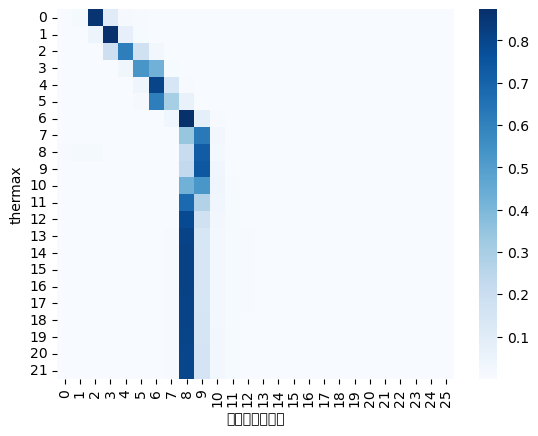

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
'''Includes padded character as well'''

# Create a heatmap using seaborn
sns.heatmap(first.cpu().detach().numpy(), cmap='Blues')

# Set labels for x-axis and y-axis
plt.xlabel("थरमैक्स")
plt.ylabel("thermax")

# Display the heatmap
plt.show()


In [76]:
decoder_predicted.shape

torch.Size([4095, 22, 68])

In [77]:
dec_predicted = torch.argmax(decoder_predicted,dim=-1)

In [78]:
dec_predicted.shape

torch.Size([4095, 22])

In [79]:
first9_words = dec_predicted[0:9]

In [80]:
print(char2int_hin)

{'_': 0, '\t': 1, '\n': 2, ' ': 3, 'ँ': 4, 'ं': 5, 'ः': 6, 'अ': 7, 'आ': 8, 'इ': 9, 'ई': 10, 'उ': 11, 'ऊ': 12, 'ऋ': 13, 'ए': 14, 'ऐ': 15, 'ऑ': 16, 'ओ': 17, 'औ': 18, 'क': 19, 'ख': 20, 'ग': 21, 'घ': 22, 'ङ': 23, 'च': 24, 'छ': 25, 'ज': 26, 'झ': 27, 'ञ': 28, 'ट': 29, 'ठ': 30, 'ड': 31, 'ढ': 32, 'ण': 33, 'त': 34, 'थ': 35, 'द': 36, 'ध': 37, 'न': 38, 'प': 39, 'फ': 40, 'ब': 41, 'भ': 42, 'म': 43, 'य': 44, 'र': 45, 'ल': 46, 'ळ': 47, 'व': 48, 'श': 49, 'ष': 50, 'स': 51, 'ह': 52, '़': 53, 'ऽ': 54, 'ा': 55, 'ि': 56, 'ी': 57, 'ु': 58, 'ू': 59, 'ृ': 60, 'ॅ': 61, 'े': 62, 'ै': 63, 'ॉ': 64, 'ो': 65, 'ौ': 66, '्': 67}


In [81]:
df_test

,English,transliteration_in_hindi
0,thermax,थरमैक्स
1,sikhaaega,सिखाएगा
2,learn,लर्न
3,twitters,ट्विटर्स
4,tirunelveli,तिरुनेलवेली
...,...,...
4091,saflata,सफ़लता
4092,shbana,शबाना
4093,khaatootolaa,खातूटोला
4094,shivastava,शिवास्तव


In [82]:
first9_words.shape

torch.Size([9, 22])

In [83]:
a=[]
for i in range(9):
    for j in range(22):
        if first9_words[i,j] == 2:
            a.append(j)

In [84]:
a

[7, 7, 5, 8, 11, 9, 9, 5, 9]

In [85]:
first9_words_eng = enc_input_data_test[:9]

In [86]:
first9_words_eng.shape

torch.Size([9, 26])

In [87]:
b=[]
for i in range(9):
    for j in range(26):
        if first9_words_eng[i,j] == 2:
            b.append(j)

In [88]:
b

[8, 10, 6, 9, 12, 13, 10, 8, 9]

In [89]:
'''The following plots doesnot contain any padded characters'''

'The following plots doesnot contain any padded characters'

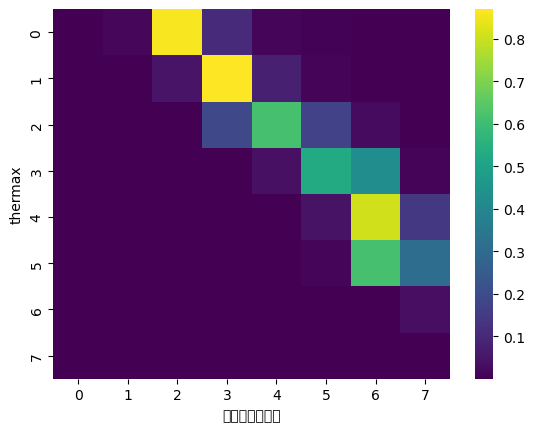

In [101]:
'''first word'''

# Create a heatmap using seaborn
sns.heatmap(attention_weights[0,0:8,0:8].cpu().detach().numpy(), cmap='viridis')

# Set labels for x-axis and y-axis
plt.xlabel("थरमैक्स")
plt.ylabel("thermax")

# Display the heatmap
plt.show()


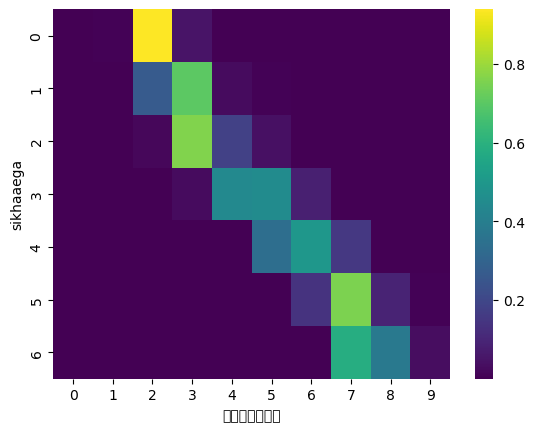

In [91]:
'''second word'''

# Create a heatmap using seaborn
sns.heatmap(attention_weights[1,0:7,0:10].cpu().detach().numpy(), cmap='viridis')

# Set labels for x-axis and y-axis
plt.xlabel("थरमैक्स")
plt.ylabel("sikhaaega")

# Display the heatmap
plt.show()


/home/agcl/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2354 (\N{DEVANAGARI LETTER LA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/agcl/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2344 (\N{DEVANAGARI LETTER NA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


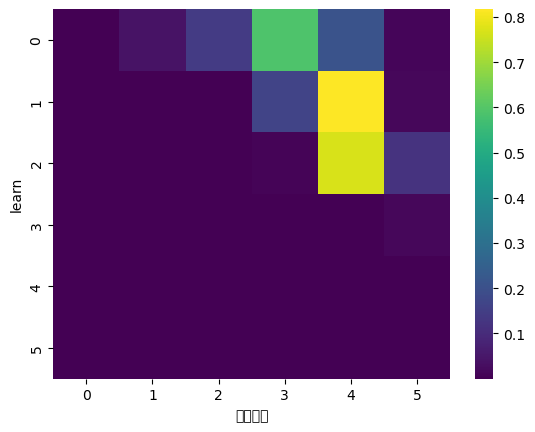

In [92]:
'''third word'''

# Create a heatmap using seaborn
sns.heatmap(attention_weights[2,0:6,0:6].cpu().detach().numpy(), cmap='viridis')

# Set labels for x-axis and y-axis
plt.xlabel("लर्न")
plt.ylabel("learn")

# Display the heatmap
plt.show()


/home/agcl/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2335 (\N{DEVANAGARI LETTER TTA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/agcl/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2357 (\N{DEVANAGARI LETTER VA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/agcl/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2367 (\N{DEVANAGARI VOWEL SIGN I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


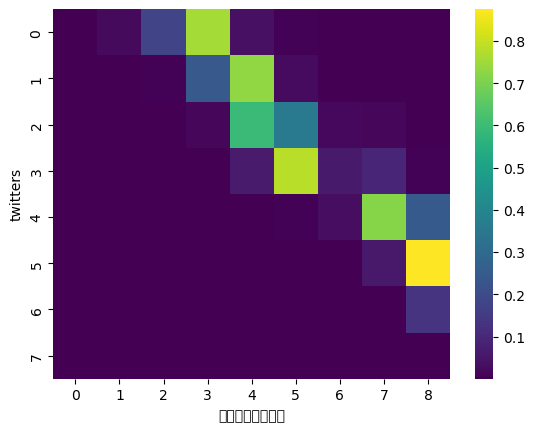

In [93]:
'''forth word'''

# Create a heatmap using seaborn
sns.heatmap(attention_weights[3,0:8,0:9].cpu().detach().numpy(), cmap='viridis')

# Set labels for x-axis and y-axis
plt.xlabel("ट्विटर्स")
plt.ylabel("twitters")

# Display the heatmap
plt.show()


/home/agcl/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2340 (\N{DEVANAGARI LETTER TA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/agcl/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2369 (\N{DEVANAGARI VOWEL SIGN U}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/agcl/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2375 (\N{DEVANAGARI VOWEL SIGN E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/agcl/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2368 (\N{DEVANAGARI VOWEL SIGN II}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


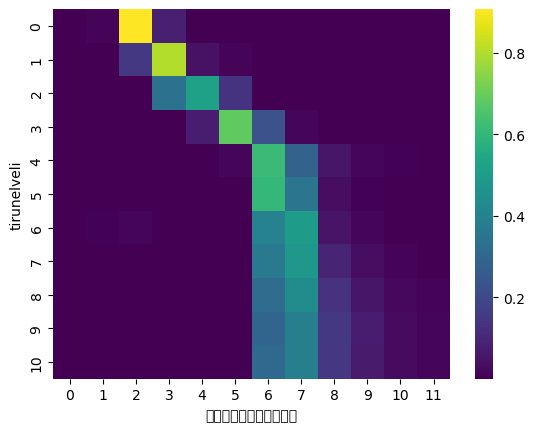

In [94]:
'''fifth word'''

# Create a heatmap using seaborn
sns.heatmap(attention_weights[4,0:11,0:12].cpu().detach().numpy(), cmap='viridis')

# Set labels for x-axis and y-axis
plt.xlabel("तिरुनेलवेली")
plt.ylabel("tirunelveli")

# Display the heatmap
plt.show()


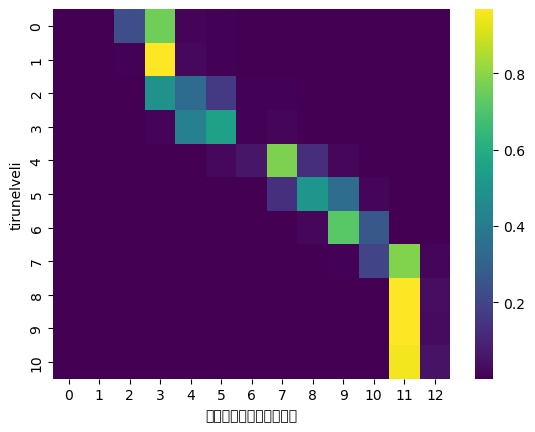

In [95]:
'''sixth word'''

# Create a heatmap using seaborn
sns.heatmap(attention_weights[5,0:11,0:13].cpu().detach().numpy(), cmap='viridis')

# Set labels for x-axis and y-axis
plt.xlabel("तिरुनेलवेली")
plt.ylabel("tirunelveli")

# Display the heatmap
plt.show()

/home/agcl/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2346 (\N{DEVANAGARI LETTER PA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/agcl/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2358 (\N{DEVANAGARI LETTER SHA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/agcl/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2351 (\N{DEVANAGARI LETTER YA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/agcl/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2379 (\N{DEVANAGARI VOWEL SIGN O}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/agcl/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2306 (\N{DEVANAGARI SIGN ANUSVARA}) missing from current font.
  fig.canvas.print_figure(byt

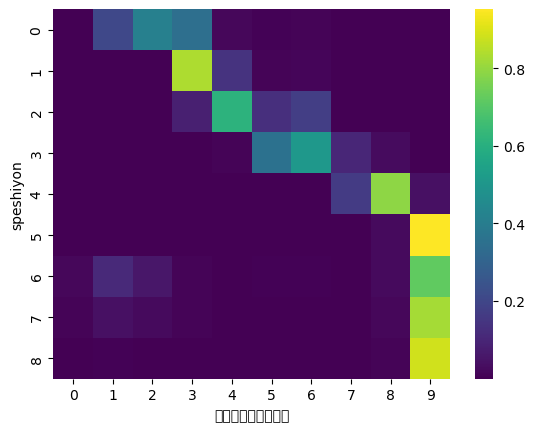

In [96]:
'''seventh word'''

# Create a heatmap using seaborn
sns.heatmap(attention_weights[6,0:9,0:10].cpu().detach().numpy(), cmap='viridis')

# Set labels for x-axis and y-axis
plt.xlabel("स्पेशियों")
plt.ylabel("speshiyon")

# Display the heatmap
plt.show()

/home/agcl/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2370 (\N{DEVANAGARI VOWEL SIGN UU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/agcl/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2307 (\N{DEVANAGARI SIGN VISARGA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


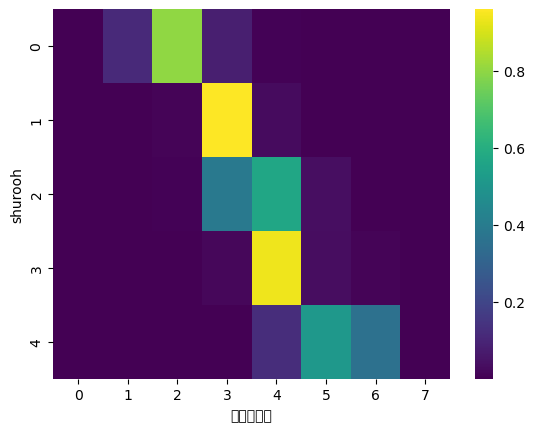

In [97]:
'''eigth word'''

# Create a heatmap using seaborn
sns.heatmap(attention_weights[7,0:5,0:8].cpu().detach().numpy(), cmap='viridis')

# Set labels for x-axis and y-axis
plt.xlabel("शुरूः")
plt.ylabel("shurooh")

# Display the heatmap
plt.show()

/home/agcl/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2361 (\N{DEVANAGARI LETTER HA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/agcl/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2366 (\N{DEVANAGARI VOWEL SIGN AA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


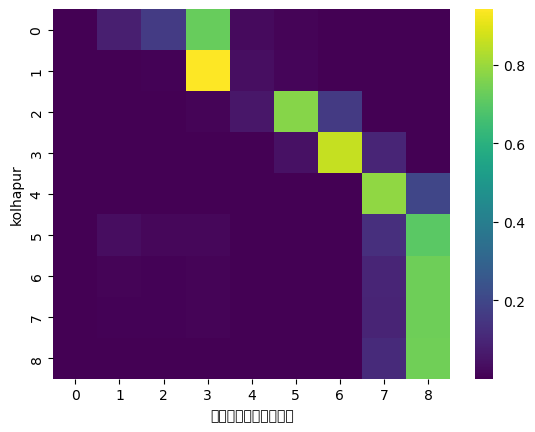

In [98]:
'''ninth word'''

# Create a heatmap using seaborn
sns.heatmap(attention_weights[8,0:9,0:9].cpu().detach().numpy(), cmap='viridis')

# Set labels for x-axis and y-axis
plt.xlabel("कोल्हापुरः")
plt.ylabel("kolhapur")

# Display the heatmap
plt.show()